<a href="https://colab.research.google.com/github/wizardcalidad/alien_vs_predator_classification_uisng_tensorflow_mobileNet/blob/main/alienVsPredator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%tensorflow_version 1.15.0 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
train_root = "/content/drive/MyDrive/Colab Notebooks/alienVspredator/alien_vs_predator_thumbnails/data/train"
test_root = "/content/drive/MyDrive/Colab Notebooks/alienVspredator/alien_vs_predator_thumbnails/data/validation"

In [3]:
image_path = train_root + "/alien/103.jpg"
def image_load(image_path):
    loaded_image = image.load_img(image_path)
    image_rel = pathlib.Path(image_path).relative_to(train_root)
    print(image_rel)
    return loaded_image

alien/103.jpg


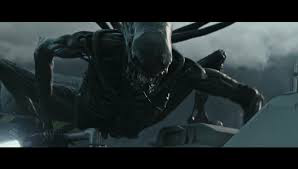

In [4]:
image_load(image_path)

In [5]:
train_generator = ImageDataGenerator(rescale=1/255) 
test_generator = ImageDataGenerator(rescale=1/255) 

train_image_data = train_generator.flow_from_directory(str(train_root),target_size=(224,224))
test_image_data = test_generator.flow_from_directory(str(test_root), target_size=(224,224))

Found 695 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2"

In [7]:
feature_extractor_url

'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'

In [8]:
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

In [9]:
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))
IMAGE_SIZE

[224, 224]

In [10]:
for image_batch, label_batch in train_image_data:
    print("Image-batch-shape:",image_batch.shape)
    print("Label-batch-shape:",label_batch.shape)
    break

Image-batch-shape: (32, 224, 224, 3)
Label-batch-shape: (32, 2)


In [22]:
for test_image_batch, test_label_batch in test_image_data:
    print("Image-batch-shape:",test_image_batch.shape)
    print("Label-batch-shape:",test_label_batch.shape)
    break

Image-batch-shape: (32, 224, 224, 3)
Label-batch-shape: (32, 2)


In [12]:
feature_extractor_layer = layers.Lambda(feature_extractor,input_shape=IMAGE_SIZE+[3])

In [13]:
feature_extractor_layer.trainable = False

In [14]:
model = Sequential([
    feature_extractor_layer,
    layers.Dense(train_image_data.num_classes, activation = "softmax")
    ])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,562
Trainable params: 2,562
Non-trainable params: 0
_________________________________________________________________


In [15]:
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [16]:
result = model.predict(image_batch)
result.shape

(32, 2)

In [17]:
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = "categorical_crossentropy",
    metrics = ['accuracy']
    )

In [18]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    
# Early stopping to stop the training if loss start to increase. It also avoids overfitting.
es = EarlyStopping(patience=2,monitor="val_loss")

In [19]:
batch_stats = CollectBatchStats()
# fitting the model
model.fit((item for item in train_image_data), epochs = 3,
         steps_per_epoch=21,
         callbacks = [batch_stats, es],validation_data=test_image_data)

Epoch 1/3
21/21 [==============================] - 464s 22s/step - loss: 0.6344 - acc: 0.6727 - val_loss: 0.3821 - val_acc: 0.8350
Epoch 2/3
21/21 [==============================] - 38s 2s/step - loss: 0.2473 - acc: 0.9062 - val_loss: 0.2419 - val_acc: 0.9150
Epoch 3/3
21/21 [==============================] - 38s 2s/step - loss: 0.1735 - acc: 0.9457 - val_loss: 0.1973 - val_acc: 0.9250


In [20]:
label_names = sorted(train_image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Alien', 'Predator'], dtype='<U8')

In [23]:
result_batch = model.predict(test_image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Alien', 'Predator', 'Alien', 'Predator', 'Predator', 'Predator',
       'Predator', 'Predator', 'Predator', 'Alien', 'Alien', 'Alien',
       'Predator', 'Alien', 'Alien', 'Alien', 'Predator', 'Alien',
       'Alien', 'Alien', 'Alien', 'Alien', 'Predator', 'Alien',
       'Predator', 'Predator', 'Alien', 'Alien', 'Alien', 'Predator',
       'Alien', 'Alien'], dtype='<U8')

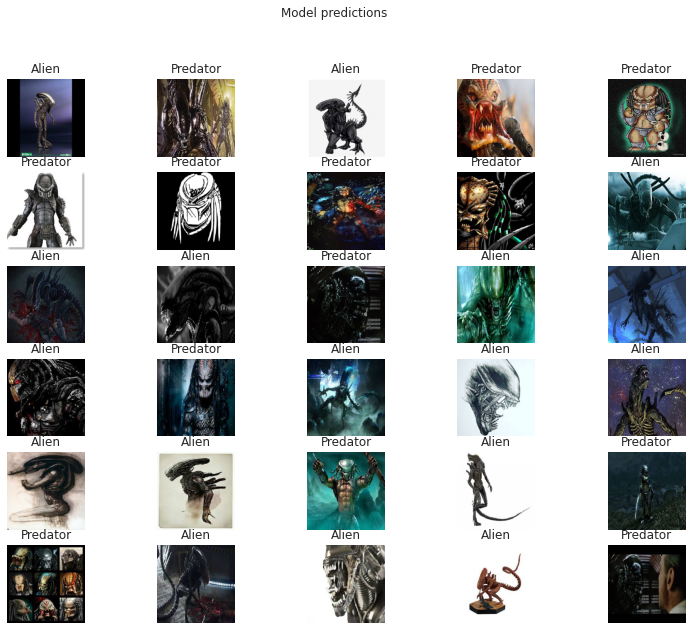

In [24]:
plt.figure(figsize=(13,10))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(test_image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
  plt.suptitle("Model predictions")

Well done! The accuracy is ~94%. Your small but powerful NN model is ready. The trade-off between performance and speed is acceptable unless it is deployable on an embedded device and gives real-time offline detection.

To have good control of building the models, I recommend running the code on different datasets. Notice the accuracy and run time. This guide has given you a brief explanation of how to use pre-trained models in the TensorFlow library and MobileNet architecture. Read the links mentioned in the guide for a better understanding. You can create compact and insanely fast classifiers using MobileNets. They are widely used in NLP applications.